In [1]:
from goods_s.objects import *

/home/tdshield/miniconda3/envs/research/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
'''
Run the double power law SFH BAGPIPES on a pixel-by-pixel basis for a single object.
'''

objid = 183825 
z = 3.04
o = obj(objid)
Ncut = 40 # Length of pixel cutout

# List of filter .par paths to feed into BAGPIPES
filters = MOSAIC_NAMES 
Nfilt = len(filters)
filt_list = []
for i in range(Nfilt):
    filt_list.append(FILTER_PAR_PATH + MOSAIC_NAMES[i] + '.par')

# Gather data cutout, error cutout, background, and Sr per pixel for each filter
data = np.zeros((Nfilt, Ncut, Ncut))
sigma = np.zeros((Nfilt, Ncut, Ncut))
bkg = np.zeros(Nfilt)
sr_pix = np.zeros(Nfilt)

for i, filt in enumerate(filters):
    data[i, :, :], sigma[i, :, :], bkg[i], sr_pix[i] = o.get_mosaic_cut(filt, n=Ncut)

snr = data / sigma # For pixel masking
sigma[snr > 20] = 0.05*data[snr > 20] # Impose 5% error floor on all pixels

# Create a mask that ensures good (>3) SNR and that pixels belong to the object in each filter
mask = np.zeros((Ncut, Ncut))
thres = 1.5 # Starting threshold for masking routine
x0 = int(Ncut/2) # Center of cutout
for i in range(Nfilt):
    segmap, cent, flag = make_segmap(data[i, :, :], sigma[i, :, :], thres, x0, int(o.a))

    while flag == False:
        thres += 0.5
        segmap, cent, flag = make_segmap(data[i, :, :], sigma[i, :, :], thres, x0, int(o.a))
        if cent == 0:
            flag = True 
    
    mask += (np.isin(segmap, cent) & (snr[i, :, :] > 3))

pix_mask = (mask > 0) # Any pixel that has SNR > 3 and is belonging to central object in ANY filter
Npix = len(data[0, pix_mask])
print(f'There are {Npix} pixels to fit with BAGPIPES')

# Apply pixel mask to data and error cutouts
masked_data = data[:, pix_mask]
masked_sig = sigma[:, pix_mask]
pixids = np.linspace(0, Npix-1, num=Npix).astype(int) # Label each pixel with an integer as ther "ID"

# Function that loads photometric data for a given pixel to feed into BAGPIPES
def load_data(pixid):
    pixid = int(pixid)
    data_MJy_Sr = masked_data[:, pixid]
    sig_MJy_Sr = masked_sig[:, pixid]

    data_muJy = np.zeros(data_MJy_Sr.shape)
    sig_muJy = np.zeros(sig_MJy_Sr.shape)
    for i in range(Nfilt):
        data_muJy[i] = MJy_Sr_to_nJy(data_MJy_Sr[i], filters[i]) * 1e-3
        sig_muJy[i] = MJy_Sr_to_nJy(sig_MJy_Sr[i], filters[i]) * 1e-3
    
    return np.array([data_muJy, sig_muJy]).T

There are 208 pixels to fit with BAGPIPES


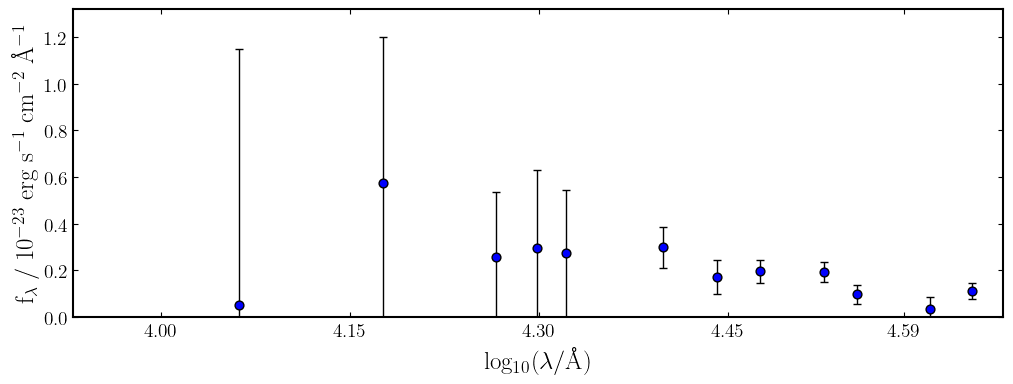

(<Figure size 1200x400 with 1 Axes>,
 [<Axes: xlabel='$\\mathrm{log_{10}}\\big(\\lambda / \\mathrm{\\AA}\\big)$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-23}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [3]:
pixid = 1
pixel = bp.galaxy(pixid, load_data, photometry_exists=True, spectrum_exists=False, filt_list=filt_list)
pixel.plot()

In [5]:
load_data(1)

array([[-5.47498721e-05,  5.42060287e-05],
       [ 2.20187063e-06,  4.88948100e-05],
       [ 4.31157481e-05,  4.70168991e-05],
       [ 2.93487779e-05,  3.13667005e-05],
       [ 3.92175981e-05,  4.40691050e-05],
       [ 4.00154069e-05,  3.99706861e-05],
       [ 6.23648713e-05,  1.85725267e-05],
       [ 4.37885794e-05,  1.82391120e-05],
       [ 5.83733285e-05,  1.49462491e-05],
       [ 7.22760294e-05,  1.63915352e-05],
       [ 4.13150537e-05,  1.77743855e-05],
       [ 2.01292862e-05,  2.64727770e-05],
       [ 7.26449234e-05,  2.23588611e-05]])

In [12]:
from os import remove
sampler = 'nautilus'
n_live, n_eff = 400, 400
fit_instructions = build_dbl_power_law_fit_instructions(z)

try:
    remove(f'pipes/posterior/test_pixel/{pixid}.h5')
except:
    pass

fit = bp.fit(pixel, fit_instructions, run='test_pixel')
fit.fit(verbose=True, n_live=n_live, n_eff=n_eff, sampler=sampler, pool=4)


Bagpipes: fitting object 1

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 16     | 1        | 4        | 9500     | N/A    | 2729  | +688.38  

Completed in 83.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dblplaw:alpha                  0.050      1.314    111.880
dblplaw:beta                   0.070      3.798    164.403
dblplaw:massformed             5.832      6.015      6.221
dblplaw:metallicity            0.235      0.810      1.822
dblplaw:tau                    0.415      1.177      1.698
dust:Av                        0.158      0.496      1.114
nebular:logU                  -2.675     -2.027     -1.326




/home/tdshield/miniconda3/envs/research/lib/python3.12/site-packages/bagpipes/models/star_formation_history.py:278: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1
/home/tdshield/miniconda3/envs/research/lib/python3.12/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/tdshield/miniconda3/envs/research/lib/python3.12/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.log10(self.sfr*self.age_of_universe) - self.formed_mass


In [13]:
sampler = 'multinest'
n_live, n_eff = 400, 400
fit_instructions = build_dbl_power_law_fit_instructions(z)

try:
    remove(f'pipes/posterior/test_pixel/{pixid}.h5')
except:
    pass

fit = bp.fit(pixel, fit_instructions, run='test_pixel')
fit.fit(verbose=True, n_live=n_live, n_eff=n_eff, sampler=sampler, pool=4)


Bagpipes: fitting object 1

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    7
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.587467
Replacements:                                450
Total Samples:                               766
Nested Sampling ln(Z):            **************
Acceptance Rate:                        0.434028
Replacements:                                500
Total Samples:                              1152
Nested Sampling ln(Z):            **************
Acceptance Rate:                        0.377229
Replacements:                                550
Total Samples:                              1458
Nested Sampling ln(Z):            **************

/home/tdshield/miniconda3/envs/research/lib/python3.12/site-packages/bagpipes/models/star_formation_history.py:278: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1
/home/tdshield/miniconda3/envs/research/lib/python3.12/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/tdshield/miniconda3/envs/research/lib/python3.12/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.log10(self.sfr*self.age_of_universe) - self.formed_mass
